# Track changes in CCG & SICBL locations

The Clinical Commissioning Groups (CCGs) and Sub-Integrated Care Board Locations (SICBLs) boundaries are defined by the Lower Super Output Areas (LSOA) that they contain and not by any other smaller region type.

The ambulance service region boundaries are also defined at the LSOA level based on the 2015 and 2018 CCG boundaries.

This means that as the CCG boundaries change over time, we should update the ambulance service regions to match.

In this notebook we show the changes in CCG and SICBL boundaries over time.

Available boundaries data from the Office for National Statistics:
+ CCG

Available LSOA-CCG and LSOA-SICBL lookup data from the Office for National Statistics:
+ LSOA 2011 to CCG 2015
+ LSOA 2011 to CCG 2021 (April)
+ LSOA 2011 to SICBL 2022 (July)

## Notebook setup

In [19]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [4]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_output_images = 'output_images'

    # Boundaries data:
    lsoa11_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'
    ccg21_geojson = 'Clinical_Commissioning_Groups_April_2021_EN_BGC_2022.geojson'
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    # Lookup data:
    lsoa11_ccg15 = 'Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(July_2015)_Lookup_in_England.csv'
    lsoa11_ccg21 = 'LSOA11_CCG21_STP21_LAD21_EN_LU.csv'
    lsoa11_sicbl22 = 'LSOA_(2011)_to_Sub_ICB_Locations_(July_2022)_Lookup_in_England.csv'


paths = Paths()

## Link CCG15 to CCG21

There are many more 2015 CCGs than 2021 CCGs. Most of the 2015 CCGs were merged into fewer larger CCGs.

Create a lookup of CCG15 to 2021 by taking a representative point from each 2015 CCG, finding which 2021 CCG contains it, and checking on a map that the results make sense.

In [13]:
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [14]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [15]:
gdf_ccg21 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg21_geojson))

In [16]:
gdf_ccg21.head(3)

,OBJECTID,CCG21CD,CCG21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,5b7e30f5-40e7-4d0c-919a-8d946b9a30fb,"POLYGON ((443219.660 409833.090, 443286.853 40..."
1,2,E38000007,NHS Basildon and Brentwood CCG,564014,194421,0.368068,51.6247,9b557a37-0357-4eed-a757-0823174dd02a,"MULTIPOLYGON (((577377.229 194031.698, 577419...."
2,3,E38000008,NHS Bassetlaw CCG,468073,384833,-0.978700,53.3560,3627680a-7aa5-47df-8ef1-c829f4b54a42,"MULTIPOLYGON (((482015.701 373909.094, 481979...."


In [17]:
def prepare_data_for_maps(
        gdf_big_regions,
        gdf_small_regions,
        col_big_regions,
        col_small_regions
    ):

    # Prevent pandas shenanigans:
    gdf_big_regions = gdf_big_regions.copy()
    gdf_small_regions = gdf_small_regions.copy()

    # Split any small region MultiPolygon into their Polygons:
    gdf_small_regions = gdf_small_regions.explode()
    # Find small region centroids and representative points:
    gdf_small_regions['centroid'] = gdf_small_regions['geometry'].centroid
    gdf_small_regions['representative_point'] = (
        gdf_small_regions['geometry'].representative_point())
    
    # --- Find containment ---
    # For each small region point, check if each big polygon contains it.
    # Create a dictionary of which big region contains each small region:
    dict_contains = {}
    
    for ind in gdf_small_regions.index:
        series_bool = gdf_big_regions['geometry'].contains(
            gdf_small_regions.loc[ind, 'representative_point'])
        
        big_ind = series_bool[series_bool == True].index
        try:
            big_name = gdf_big_regions.loc[big_ind, col_big_regions].values[0]
            small_name = gdf_small_regions.loc[ind, col_small_regions]
            
            dict_contains[small_name] = big_name
        except IndexError:
            # This point isn't in any big regions.
            # (e.g. point in Scotland, big regions only England).
            pass
    # Turn the dictionary into a Series:
    series_contains = pd.Series(dict_contains)
    series_contains.index.name = col_small_regions
    series_contains.name = col_big_regions

    # Merge the containment series:
    gdf_small_regions = pd.merge(
        gdf_small_regions, series_contains,
        left_on=col_small_regions, right_index=True, how='right'
    )

    # --- Colours ---
    # Assign a colour to each big region:
    # Assign colour numbers.
    # Use 'distance' balance to use as few colours as possible.
    gdf_big_regions['adjacent_colours'] = greedy(
        gdf_big_regions, min_distance=1,
        # balance='distance',
        balance='count',
    ).astype(str)
    
    # Make a list of colour names:
    # Expecting to only need about six colours for this example.
    colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid',
               'Orchid', 'Plum', 'Lavender']
    
    # Make a dictionary of numbers to colours.
    # The keys are the numbers in the `adjacent_colours` column:
    keys = [f'{i}' for i in range(len(colours))]
    colour_map = dict(zip(keys, colours))
    
    # Assign these colours to the regions:
    gdf_big_regions['colour_str'] = (
        gdf_big_regions['adjacent_colours'].map(colour_map))
    
    # Copy over the colours to the small region data:
    colour_series = gdf_big_regions[[col_big_regions, 'colour_str']]
    gdf_small_regions = pd.merge(
        gdf_small_regions, colour_series,
        on=col_big_regions, how='left'
        )

    return gdf_big_regions, gdf_small_regions

In [20]:
gdf_ccg21_for_map, gdf_ccg15_for_map = prepare_data_for_maps(
    gdf_ccg21,
    gdf_ccg15,
    'CCG21CD',
    'ccg15cd',
)

/tmp/ipykernel_7187/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


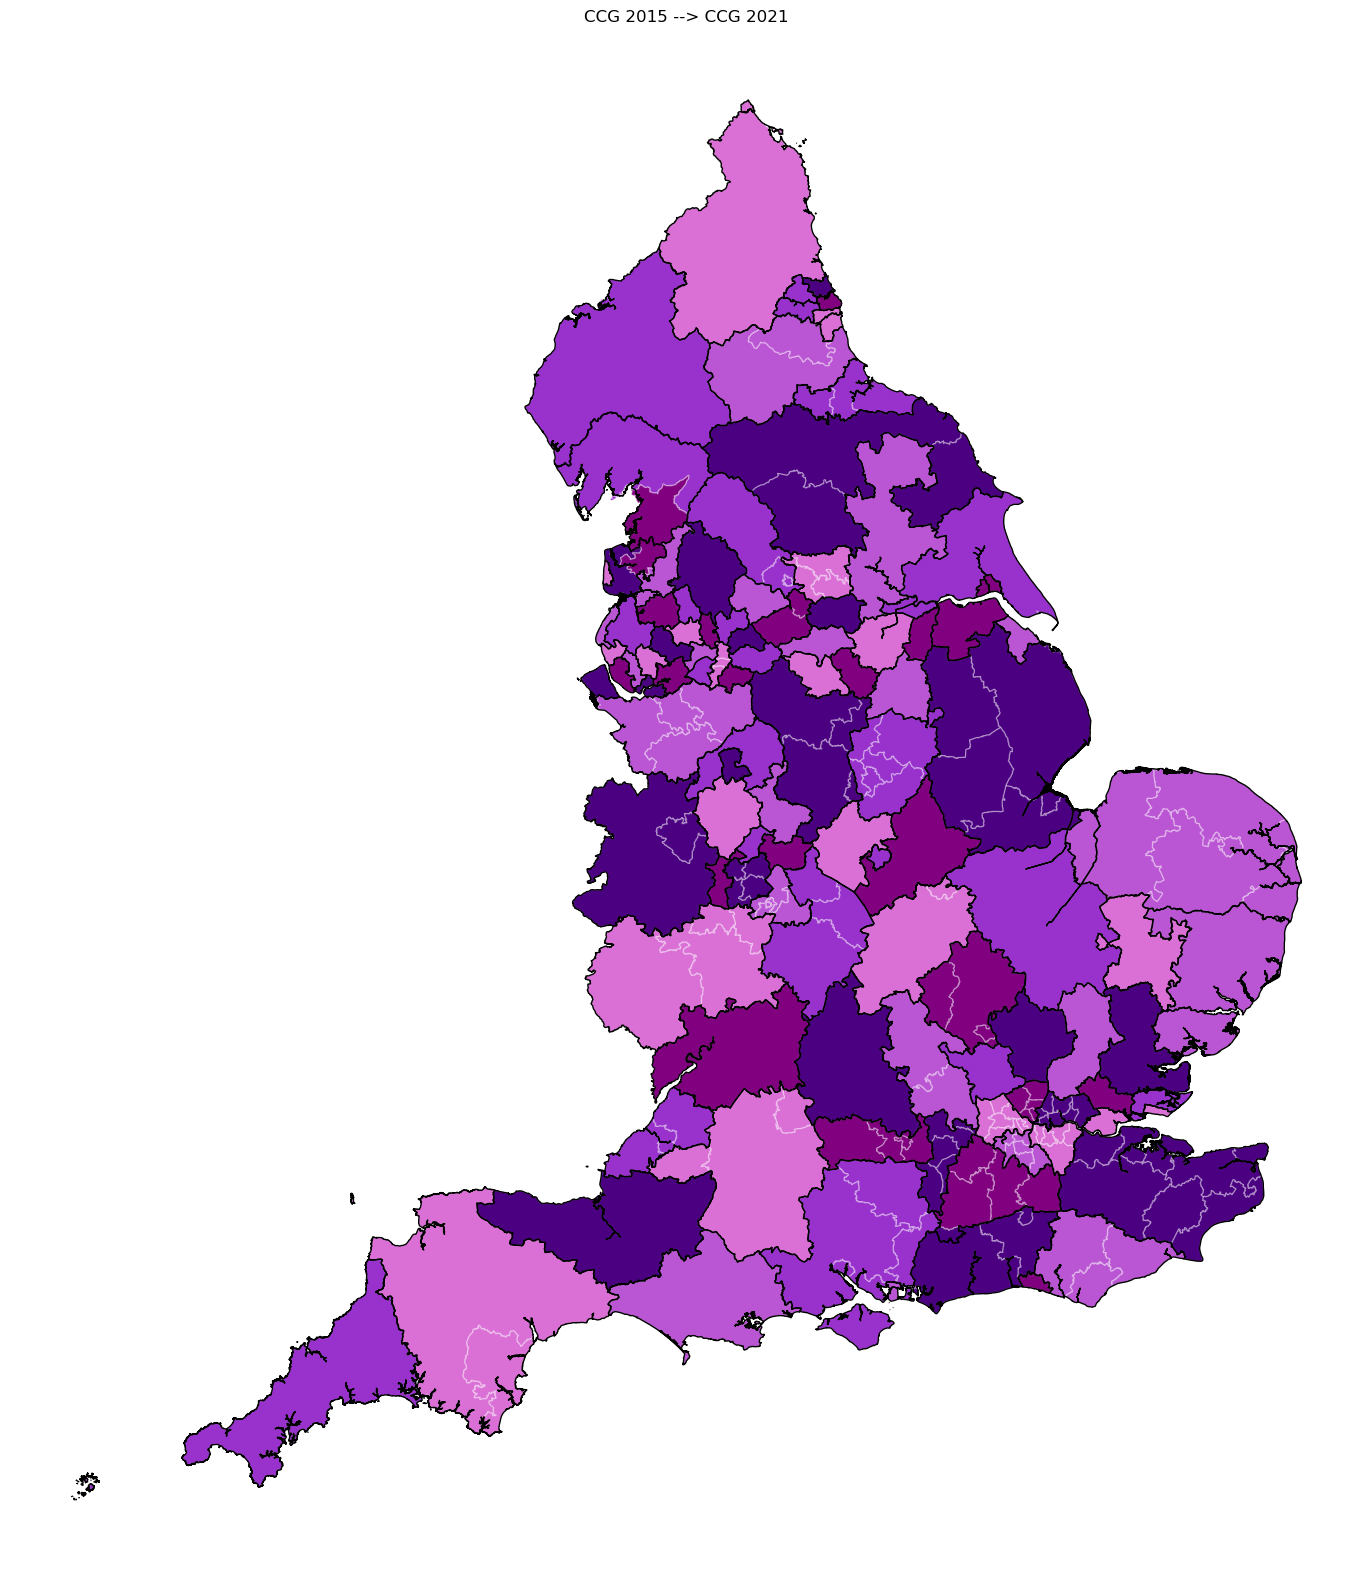

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_ccg15_for_map.plot(ax=ax, edgecolor='#ffffff55', facecolor=gdf_ccg15_for_map['colour_str'])
gdf_ccg21_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title('CCG 2015 --> CCG 2021')

# plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_lad15), bbox_inches='tight')
plt.show()

The shapes mostly match well except for various bits near Morecambe. Those areas are well within the North East ambulance service boundaries. The exact CCG boundaries there change several times between 2015 and 2021.

There's also a mismatch near north-east Sussex.